# Sepsis-3 in MIMIC-III

This is the primary notebook for analyzing sepsis-3 in the MIMIC-III database. Before running this notebook, you'll need the `sepsis3-df.csv` file in the local directory: either by downloading it directly from PhysioNet or running the SQL scripts enclosed on the MIMIC-III database. See `sepsis-3-get-data.ipynb` for more detail.

In [2]:
from __future__ import print_function

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import tableone
from collections import OrderedDict
from statsmodels.formula.api import logit
from IPython.display import display, HTML # used to print out pretty pandas dataframes

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# used to calculate AUROC/accuracy
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples

# path used for data - can be a relative path to the current folder
data_path = 'data'

%matplotlib inline
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

In [3]:
df = pd.read_csv(os.path.join(data_path,'sepsis3-df.csv'))

# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)


for c in ['intime','outtime',
          'suspected_infection_time_mv','suspected_infection_time',
          'suspected_infection_time_poe', 'blood_culture_time']:
    if c in df.columns:
        if df[c].dtype == 'object':
            df[c] = pd.to_datetime(df[c])

# list of the sepsis definitions
sepsis_list = ['sepsis_angus','sepsis_martin', 'sepsis_explicit',
               'sepsis_cdc','sepsis_nqf',
               'sepsis-3']

In [10]:
df[df['sepsis-3'] == 1].columns

Index(['icustay_id', 'hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'race_white', 'race_black', 'race_hispanic',
       'race_other', 'metastatic_cancer', 'diabetes', 'height', 'weight',
       'bmi', 'first_service', 'hospital_expire_flag', 'thirtyday_expire_flag',
       'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin',
       'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit',
       'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'elixhauser_hospital',
       'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'composite_outcome',
       'blood culture', 'suspicion_poe', 'abx_poe', 'sepsis-3', 'sofa>=2',
       'race'],
      dtype='object')

# Results for Abstract

In [4]:
# see get-data for the exclusions
print('{:5g} patients.'.format(df.shape[0]))

print('{:5g} ({:2.0f}%) suspected of infection.'.format(
        df['suspicion_poe'].sum(), df['suspicion_poe'].sum()*100.0/df.shape[0]))

print('{:5g} ({:2.2f}%) have SOFA >= 2.'.format(
    df['sofa>=2'].sum(),100.0*df['sofa>=2'].mean()))

print('{:5g} ({:2.2f}%) have Sepsis-3 criteria (intersection of above two).'.format(
    df['sepsis-3'].sum(),100.0*df['sepsis-3'].mean()))

print('{:5g} ({:2.2f}%) have suspicion and SOFA < 2.'.format(
        ((df['sofa>=2']==0) & (df['suspicion_poe']==1)).sum(),
        ((df['sofa>=2']==0) & (df['suspicion_poe']==1)).sum()*100.0/df.shape[0]))

for c in sepsis_list:
    print('{:5g} ({:3.2f}%) - {}'.format(
        df[c].sum(), df[c].sum()*100.0/df.shape[0], c))

print('{:5g} ({:2.2f}%) have Sepsis-3 criteria but not Angus.'.format(
        ((df['sepsis_angus']==0) & (df['sepsis-3']==1)).sum(),
        ((df['sepsis_angus']==0) & (df['sepsis-3']==1)).sum()*100.0/df.shape[0]))


np.random.seed(21381)
# cronbach alpha for construct validity
calpha = su.cronbach_alpha_table(df, sepsis_list)

# remove "sepsis_" prefix from columns/indices
calpha.columns = [x.replace('sepsis_','') for x in calpha.columns]
calpha.index = [x.replace('sepsis_','') for x in calpha.index]

print('\n === Cronbach Alpha ===')
display(HTML(calpha.fillna('').to_html()))

11791 patients.
 7061 (60%) suspected of infection.
 8868 (75.21%) have SOFA >= 2.
 5784 (49.05%) have Sepsis-3 criteria (intersection of above two).
 1277 (10.83%) have suspicion and SOFA < 2.
 3368 (28.56%) - sepsis_angus
 1734 (14.71%) - sepsis_martin
 1062 (9.01%) - sepsis_explicit
 3761 (31.90%) - sepsis_cdc
 1302 (11.04%) - sepsis_nqf
 5784 (49.05%) - sepsis-3
 2917 (24.74%) have Sepsis-3 criteria but not Angus.

 === Cronbach Alpha ===


,angus,martin,explicit,cdc,nqf,sepsis-3
angus,,0.69 [0.68-0.70],0.62 [0.61-0.63],0.62 [0.60-0.63],0.63 [0.62-0.65],0.62 [0.61-0.64]
martin,,,0.85 [0.84-0.85],0.54 [0.52-0.55],0.91 [0.90-0.92],0.49 [0.48-0.50]
explicit,,,,0.49 [0.48-0.51],0.89 [0.89-0.90],0.40 [0.39-0.41]
cdc,,,,,0.53 [0.52-0.55],0.76 [0.75-0.76]
nqf,,,,,,0.45 [0.43-0.46]


# Results section

We now print out the results in the same order as they are in the paper.

# Demographics

In [5]:
# Call the print_demographics subfunction, which prints out a reasonably formatted table
su.print_demographics(df)

print('\nAlive vs. dead')
su.print_demographics(df, idx=(df.hospital_expire_flag.values==1))

print('')

print('{:5g} have SIRS >= 2 ({:2.2f}%) on admission.'.format(
    (df.sirs.values >= 2).sum(),100.0*(df.sirs.values >= 2).mean()))

print('{:5g} have qSOFA >= 2 ({:2.2f}%) on admission.'.format(
    (df.qsofa.values >= 2).sum(),100.0*(df.qsofa.values >= 2).mean()))

print('{:5g} have SOFA >= 2 ({:2.2f}%).'.format(
    (df.sofa.values >= 2).sum(),100.0*(df.sofa.values >= 2).mean()))

print('{:5g} have LODS >= 2 ({:2.2f}%).'.format(
    (df.lods.values >= 2).sum(),100.0*(df.lods.values >= 2).mean()))

N                   	11791
age                 	64.5 [51.1, 78.5]
gender              	6478 (54.9%)
bmi                 	28.5 +- 8.0
Race                	
White               	8497 (72.1%)
Black               	1110 (9.4%)
Hispanic            	 457 (9.4%)
elixhauser_hospital 	0.0 [0.0, 0.0]
qsofa               	2.0 [1.0, 2.0]
sirs                	3.0 [2.0, 3.0]
sofa                	3.0 [2.0, 5.0]
mlods               
lactate_max         
vent                	4149 (35.2%)
icu_los             	1.9 [1.1, 3.5]
hosp_los            	5.6 [3.1, 9.6]
thirtyday_expire_flag	1619 (13.7%)
hospital_expire_flag	1277 (10.8%)

Alive vs. dead
N                   	10514     	1277     	     
age                 	63.3 [50.0, 77.5]	74.9 [61.8, 83.7]	< 0.001
gender              	5795 (55.1%)	 683 (53.5%)	0.281
bmi                 	28.6 +- 7.6	28.1 +- 11.4	0.416


AttributeError: 'DataFrame' object has no attribute 'ix'

## Frequency of primary/secondary outcomes for each score

First print a table, then plot the figure.

In [6]:
# list probability of outcome for each score
scores = ['suspicion_poe','sofa>=2',
          'sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit',
          'sepsis_cdc','sepsis_nqf']

scores_dict = {
    'suspicion_poe': 'Suspected infection',
    'sofa>=2': 'SOFA >= 2',
    'sepsis-3': 'Sepsis-3',
    'sepsis_angus': 'Angus et al. criteria',
    'sepsis_martin': 'Martin et al. criteria',
    'sepsis_explicit': 'Explicit',
    'sepsis_cdc': 'CDC',
    'sepsis_nqf': 'CMS'
}
target_header = "hospital_expire_flag"
idx = df[target_header]==1

print()
print('=== {} ==='.format(target_header))
print()
print('{:15s}\t{:8s}\t{:5s}\t{:5s}'.format(
    'Criteria','N','p(death|c)', 'p(death|~c)'))
for c in scores:
    print('{:15s}\t{:4d}, {:2.1f}%\t{:2.1f}%\t\t{:2.1f}%'.format(
            c,
            np.sum( df[c]==1 ),
            np.sum( df[c]==1 )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idx )*100.0 / np.sum( df[c]!=1 )
        ))
    
target_header = "composite_outcome"
idx = df[target_header]==1

print()
print('=== {} ==='.format(target_header))
print()

print('{:15s}\t{:8s}\t{:5s}\t{:5s}'.format(
    'Criteria','N','p(death|c)', 'p(death|~c)'))
for c in scores:
    print('{:15s}\t{:4d}, {:2.1f}%\t{:2.1f}%\t\t{:2.1f}%'.format(
            c,
            np.sum( df[c]==1 ),
            np.sum( df[c]==1 )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idx )*100.0 / np.sum( df[c]!=1 )
        ))


=== hospital_expire_flag ===

Criteria       	N       	p(death|c)	p(death|~c)
suspicion_poe  	7061, 59.9%	12.5%		8.3%
sofa>=2        	8868, 75.2%	13.2%		3.6%
sepsis-3       	5784, 49.1%	14.5%		7.3%
sepsis_angus   	3368, 28.6%	17.9%		8.0%
sepsis_martin  	1734, 14.7%	22.7%		8.8%
sepsis_explicit	1062, 9.0%	30.1%		8.9%
sepsis_cdc     	3761, 31.9%	18.6%		7.2%
sepsis_nqf     	1302, 11.0%	27.2%		8.8%

=== composite_outcome ===

Criteria       	N       	p(death|c)	p(death|~c)
suspicion_poe  	7061, 59.9%	46.3%		19.9%
sofa>=2        	8868, 75.2%	41.2%		19.2%
sepsis-3       	5784, 49.1%	50.0%		21.9%
sepsis_angus   	3368, 28.6%	61.2%		25.5%
sepsis_martin  	1734, 14.7%	60.1%		31.5%
sepsis_explicit	1062, 9.0%	70.7%		32.2%
sepsis_cdc     	3761, 31.9%	61.1%		23.8%
sepsis_nqf     	1302, 11.0%	64.7%		32.1%


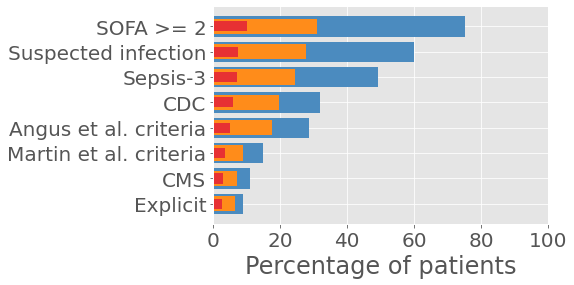


Criteria       	N       	p(death|c)	p(death|~c)	p(comp|c)	p(comp|~c)
sofa>=2        	8868, 75.2%	13.2%		3.6%		41.2%		19.2%
suspicion_poe  	7061, 59.9%	12.5%		8.3%		46.3%		19.9%
sepsis-3       	5784, 49.1%	14.5%		7.3%		50.0%		21.9%
sepsis_cdc     	3761, 31.9%	18.6%		7.2%		61.1%		23.8%
sepsis_angus   	3368, 28.6%	17.9%		8.0%		61.2%		25.5%
sepsis_martin  	1734, 14.7%	22.7%		8.8%		60.1%		31.5%
sepsis_nqf     	1302, 11.0%	27.2%		8.8%		64.7%		32.1%
sepsis_explicit	1062, 9.0%	30.1%		8.9%		70.7%		32.2%


In [7]:
# create a figure of the above frequencies
scores = ['suspicion_poe','sofa>=2',
          'sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit',
          'sepsis_cdc','sepsis_nqf']

scores_dict = {
    'suspicion_poe': 'Suspected infection',
    'sofa>=2': 'SOFA >= 2',
    'sepsis-3': 'Sepsis-3',
    'sepsis_angus': 'Angus et al. criteria',
    'sepsis_martin': 'Martin et al. criteria',
    'sepsis_explicit': 'Explicit',
    'sepsis_cdc': 'CDC',
    'sepsis_nqf': 'CMS'
}

idx = df['hospital_expire_flag']==1
idxComp = df['composite_outcome']==1

score_plot = np.zeros( [len(scores), 3] )
for i, c in enumerate(scores):
    # proportion of patients
    score_plot[i, 0] = np.sum( df[c]==1 )*100.0/df.shape[0]
    
    # with mort
    score_plot[i, 1] = np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 )
    # with comp
    score_plot[i, 2] = np.sum( (df[c]==1)&idxComp )*100.0 / np.sum( df[c]==1 )
    
S = len(scores)

idxSort = np.argsort(score_plot[:,0])
plt.figure()
plt.barh( range(S), score_plot[idxSort,0], color=col[1], align='center')
plt.barh( range(S), score_plot[idxSort,0]*score_plot[idxSort,2]/100.0, color=col[3], align='center', height=0.6)
plt.barh( range(S), score_plot[idxSort,0]*score_plot[idxSort,1]/100.0, color=col[0], align='center', height=0.4)

plt.yticks(range(S), [scores_dict[scores[x]] for x in idxSort])
plt.xlabel('Percentage of patients')
plt.xlim([0,100])
plt.show()

print('')
print('{:15s}\t{:8s}\t{:5s}\t{:5s}\t{:5s}\t{:5s}'.format(
    'Criteria','N','p(death|c)', 'p(death|~c)', 'p(comp|c)', 'p(comp|~c)'))
for i in idxSort[-1::-1]:
    c=scores[i]
    print('{:15s}\t{:4d}, {:2.1f}%\t{:2.1f}%\t\t{:2.1f}%\t\t{:2.1f}%\t\t{:2.1f}%'.format(
            c,
            np.sum( df[c]==1 ),
            np.sum( df[c]==1 )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idx )*100.0 / np.sum( df[c]!=1 ),
            np.sum( (df[c]==1)&idxComp )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idxComp )*100.0 / np.sum( df[c]!=1 )
        ))
    

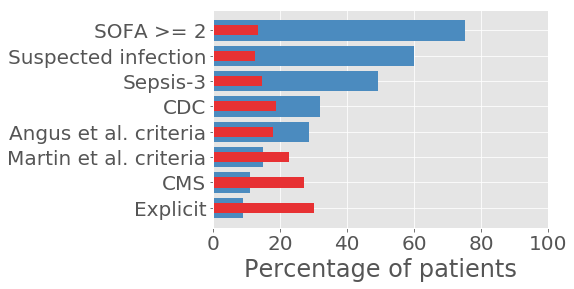

In [7]:
# print the frequencies
# list probability of outcome for each score
scores = ['suspicion_poe','sofa>=2',
          'sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit',
          'sepsis_cdc','sepsis_nqf']

scores_dict = {
    'suspicion_poe': 'Suspected infection',
    'sofa>=2': 'SOFA >= 2',
    'sepsis-3': 'Sepsis-3',
    'sepsis_angus': 'Angus et al. criteria',
    'sepsis_martin': 'Martin et al. criteria',
    'sepsis_explicit': 'Explicit',
    'sepsis_cdc': 'CDC',
    'sepsis_nqf': 'CMS'
}

idx = df['hospital_expire_flag']==1
idxComp = df['composite_outcome']==1

score_plot = np.zeros( [len(scores), 3] )
for i, c in enumerate(scores):
    # proportion of patients
    score_plot[i, 0] = np.sum( df[c]==1 )*100.0/df.shape[0]
    
    # with mort
    score_plot[i, 1] = np.sum((df[c]==1)&idx)*100.0 / np.sum( df[c]==1 )
    # with comp
    score_plot[i, 2] = np.sum( (df[c]==1)&idxComp )*100.0 / np.sum( df[c]==1 )
    
S = len(scores)

idxSort = np.argsort(score_plot[:,0])

plt.figure()
plt.barh( range(S), score_plot[idxSort,0], color=col[1], align='center', label='Patients')
#plt.barh( range(S), score_plot[idxSort,2], color=col[3], align='center', height=0.6)
plt.barh( range(S), score_plot[idxSort,1], color=col[0], align='center', height=0.4, label='Patients who died')
#ax2.set_xlim(ax2.get_xlim()[::-1])

#plt.plot( score_plot[idxSort,1], range(S), color=col[0], marker='o', markersize=10)
#ax1.barh( range(S), score_plot[idxSort,0]*score_plot[idxSort,2]/100.0, color=col[3], align='center', height=0.6)
#
#ax2 = ax1.twiny()
#ax2.barh( range(S), (score_plot[idxSort,0]*score_plot[idxSort,1]/100.0), color=col[0], align='center', height=0.4)
#ax2.set_xlim(ax2.get_xlim()[::-1])
#ax2.plot(range(S), score_plot[idxSort,0]*score_plot[idxSort,1]/100.0, color=col[0] )

plt.yticks(range(S), [scores_dict[scores[x]] for x in idxSort])
plt.xlabel('Percentage of patients')
#plt.legend(loc='lower right')
plt.xlim([0,100])
plt.show()

In [8]:
# create a dataframe for these probabilities
df_outcome = pd.DataFrame(columns=['Criteria','N','p(death|c)', 'p(death|~c)', 'p(comp|c)', 'p(comp|~c)'], dtype=float)
# same print but to csv
for i in idxSort[-1::-1]:
    c=scores[i]
    df_outcome.loc[scores_dict[c], :] = [np.sum( df[c]==1 ),
            np.sum( df[c]==1 )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idx )*100.0 / np.sum( df[c]!=1 ),
            np.sum( (df[c]==1)&idxComp )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idxComp )*100.0 / np.sum( df[c]!=1 )]
    #print('{},{:4d} {:2.1f}%,{:2.1f}%,{:2.1f}%,{:2.1f}%,{:2.1f}%'.format(
    #    ))
    
# display .. maximum of 2 decimal places
display(HTML(df_outcome.round(decimals=2).to_html()))

,Criteria,N,p(death|c),p(death|~c),p(comp|c),p(comp|~c)
SOFA >= 2,8868.0,75.21,13.22,3.59,41.16,19.19
Suspected infection,7061.0,59.88,12.55,8.27,46.34,19.85
Sepsis-3,5784.0,49.05,14.45,7.34,50.03,21.92
CDC,3761.0,31.90,18.64,7.17,61.07,23.84
Angus et al. criteria,3368.0,28.56,17.90,8.00,61.19,25.53
Martin et al. criteria,1734.0,14.71,22.72,8.78,60.09,31.51
CMS,1302.0,11.04,27.19,8.80,64.75,32.11
Explicit,1062.0,9.01,30.13,8.92,70.72,32.25


In [9]:
# note: we need to subselect to the cohort suspected of infection in order to compare AUROCs to previous literature
idx = df['suspicion_poe'].values == 1
pred_header = 'sofa'

print('Comparison to past literature performance.')
#print'{}'


df_past_literature = pd.DataFrame(columns=['hospital_expire_flag','composite_outcome'])
df_past_literature.loc['Seymour et al., 2016',:] = ['0.74 [0.73 - 0.76]', '~0.74 (inferred from eFigure 6)']
df_past_literature.loc['Raith et al., 2017',:] = ['0.753 [0.750 - 0.757]', '0.736 [0.733 - 0.739]']
np.random.seed(7891)
# AUROC of sofa for in-hospital mortality
target_header = 'hospital_expire_flag'
auc_hosp, ci_hosp = ru.calc_auc(df.loc[idx, pred_header].values, df.loc[idx, target_header].values, with_ci=True)
target_header = 'composite_outcome'
auc_comp, ci_comp = ru.calc_auc(df.loc[idx, pred_header].values, df.loc[idx, target_header].values, with_ci=True)

df_past_literature.loc['Our results', :] = ['{:0.3f} [{:0.3f} - {:0.3f}]'.format(auc_hosp, ci_hosp[0], ci_hosp[1]),
                                           '{:0.3f} [{:0.3f} - {:0.3f}]'.format(auc_comp, ci_comp[0], ci_comp[1])]


display(HTML(df_past_literature.to_html()))

Comparison to past literature performance.


,hospital_expire_flag,composite_outcome
"Seymour et al., 2016",0.74 [0.73 - 0.76],~0.74 (inferred from eFigure 6)
"Raith et al., 2017",0.753 [0.750 - 0.757],0.736 [0.733 - 0.739]
Our results,0.740 [0.722 - 0.759],0.688 [0.676 - 0.701]


In the above, it is worth noting that:

* The results of Seymour et al. are for a model incorporating age, gender, race, and comorbid status
* The results of Raith et al. are for the uncalibrated univariable score ("crude")

In [10]:
# operating point statistics on sofa >= 2
yhat_dict = OrderedDict([['SOFA>=2', df['sofa>=2']]
                        ])
stats_all = su.get_op_stats(yhat_dict, df[target_header].values)
su.print_op_stats(stats_all)

Metric

     	SOFA>=2 
TN   	 2362
FP   	 5218
FN   	  561
TP   	 3650
Sens 	87 [86, 88]
Spec 	31 [30, 32]
PPV  	41 [40, 42]
NPV  	81 [79, 82]
F1   	 55.81   
NTP  	 30.96   
NFP  	 44.25   


# Sepsis

Create the sepsis-3 criteria: SOFA >= 2 and suspicion of infection.

In [11]:
print('{:5g} ({:3.2f}%)  first ICU stay for adults.'.format(
        df['icustay_id'].count(), 100))
print('{:5g} ({:3.2f}%)  suspected of infection'.format(
        np.sum(df['suspicion_poe']),
        np.sum(df['suspicion_poe'])*100.0/df.shape[0]))
print('{:5g} ({:3.2f}%)  with a positive blood culture'.format(
    df['blood_culture_positive'].sum(), df['blood_culture_positive'].sum()*100.0/df.shape[0]))

print()
for i, c in enumerate(labels):
    print('{:5g} ({:3.2f}%) - {}'.format(
        df[c].sum(), df[c].sum()*100.0/df.shape[0], c))

11791 (100.00%)  first ICU stay for adults.
 7061 (59.88%)  suspected of infection
 2803 (23.77%)  with a positive blood culture

 7061 (59.88%) - suspicion_poe


## Venn diagrams of Sepsis-3 against other criteria

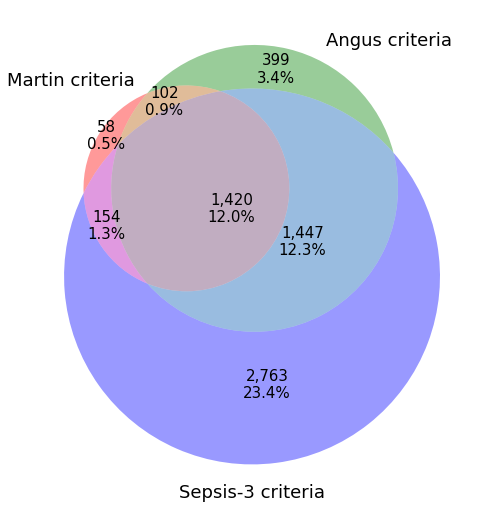

1420 patients (12.0%) satisfied all criteria.
5448 patients (46.2%) satisfied no criteria.
12.9% (1522) - sepsis_angus & sepsis_martin
13.3% (1574) - sepsis-3 & sepsis_martin
24.3% (2867) - sepsis-3 & sepsis_angus


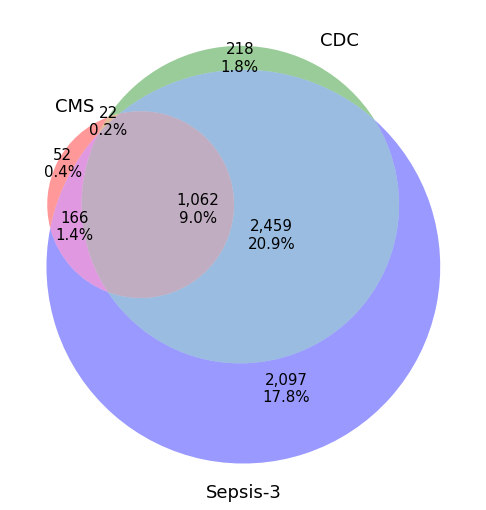

1062 patients (9.0%) satisfied all criteria.
5715 patients (48.5%) satisfied no criteria.
9.2% (1084) - sepsis_cdc & sepsis_nqf
10.4% (1228) - sepsis-3 & sepsis_nqf
29.9% (3521) - sepsis-3 & sepsis_cdc


In [12]:
# define labels here
# first label = red (top left)
# second label = green (top right)
# third label = blue (bottom)

venn_labels = OrderedDict([
        ['sepsis_martin', 'Martin criteria'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis-3', 'Sepsis-3 criteria']
    ])
su.create_venn_diagram(df, venn_labels)

venn_labels = OrderedDict([
        ['sepsis_nqf', 'CMS'],
        ['sepsis_cdc', 'CDC'],
        ['sepsis-3', 'Sepsis-3']
    ])
su.create_venn_diagram(df, venn_labels)

# Mortality rates for each group

In [13]:
target_header = "hospital_expire_flag"
idx = df[target_header]==1

# make a confusion matrix with multiple scores in each square
scores = ['sepsis_angus','sepsis_martin','sepsis_explicit','suspicion_poe','sepsis-3','sofa>=2']

print('{:15s} {:15s} {:15s}'.format('0','dead','alive','outcome %'))

for c in scores:
    print('{:15s} {:4d} {:1.1f}%\t{:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]!=1)&idx ),  np.sum( (df[c]!=1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&~idx ), np.sum( (df[c]!=1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&idx )*100.0/np.sum(df[c]!=1)
        ))
print()
print('1')
for c in scores:
    print('{:15s} {:4d} {:1.1f}%\t{:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]==1)&idx ),  np.sum( (df[c]==1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&~idx ), np.sum( (df[c]==1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0/np.sum(df[c]==1)
        ))

0               dead            alive          
sepsis_angus     674 5.7%	 7749 65.7%  8.0%
sepsis_martin    883 7.5%	 9174 77.8%  8.8%
sepsis_explicit  957 8.1%	 9772 82.9%  8.9%
suspicion_poe    391 3.3%	 4339 36.8%  8.3%
sepsis-3         441 3.7%	 5566 47.2%  7.3%
sofa>=2          105 0.9%	 2818 23.9%  3.6%

1
sepsis_angus     603 5.1%	 2765 23.5%  17.9%
sepsis_martin    394 3.3%	 1340 11.4%  22.7%
sepsis_explicit  320 2.7%	  742 6.3%  30.1%
suspicion_poe    886 7.5%	 6175 52.4%  12.5%
sepsis-3         836 7.1%	 4948 42.0%  14.5%
sofa>=2         1172 9.9%	 7696 65.3%  13.2%


# Composite outcome for each group

In [14]:
target_header = "composite_outcome"
idx = (df['hospital_expire_flag']==1) | (df['icu_los']>=3)

# make a confusion matrix with multiple scores in each square
scores = ['sepsis_angus','sepsis_martin','sepsis_explicit','suspicion_poe','sepsis-3','sofa>=2']


print('{:15s} {:12s} {:15s}'.format('0','dead/hi-LOS','alive/lo-LOS','outcome %'))

for c in scores:
    print('{:15s} {:4d} {:1.1f}%   {:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]!=1)&idx ),  np.sum( (df[c]!=1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&~idx ), np.sum( (df[c]!=1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&idx )*100.0/np.sum(df[c]!=1)
        ))
print()
print('1')
for c in scores:
    print('{:15s} {:4d} {:1.1f}%   {:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]==1)&idx ),  np.sum( (df[c]==1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&~idx ), np.sum( (df[c]==1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0/np.sum(df[c]==1)
        ))

0               dead/hi-LOS  alive/lo-LOS   
sepsis_angus    2150 18.2%    6273 53.2%  25.5%
sepsis_martin   3169 26.9%    6888 58.4%  31.5%
sepsis_explicit 3460 29.3%    7269 61.6%  32.2%
suspicion_poe    939 8.0%    3791 32.2%  19.9%
sepsis-3        1317 11.2%    4690 39.8%  21.9%
sofa>=2          561 4.8%    2362 20.0%  19.2%

1
sepsis_angus    2061 17.5%    1307 11.1%  61.2%
sepsis_martin   1042 8.8%     692 5.9%  60.1%
sepsis_explicit  751 6.4%     311 2.6%  70.7%
suspicion_poe   3272 27.7%    3789 32.1%  46.3%
sepsis-3        2894 24.5%    2890 24.5%  50.0%
sofa>=2         3650 31.0%    5218 44.3%  41.2%


# Mortality: operating point statistics

In [15]:
target_header = "hospital_expire_flag"

# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA', df.sofa.values >= 2],
                        ['SIRS', df.sirs.values >= 2],
                        ['qSOFA', df.qsofa.values >= 2]])

stats_all = su.get_op_stats(yhat_dict, df[target_header].values)

su.print_op_stats(stats_all)

Metric

     	SOFA    	SIRS    	qSOFA   
TN   	 2818		 1536		 4031
FP   	 7696		 8978		 6483
FN   	  105		   66		  263
TP   	 1172		 1211		 1014
Sens 	92 [90, 93]	95 [93, 96]	79 [77, 82]
Spec 	27 [26, 28]	15 [14, 15]	38 [37, 39]
PPV  	13 [13, 14]	12 [11, 13]	14 [13, 14]
NPV  	96 [96, 97]	96 [95, 97]	94 [93, 95]
F1   	 23.10   	 21.12   	 23.11   
NTP  	 9.94   	 10.27   	 8.60   
NFP  	 65.27   	 76.14   	 54.98   


# Composite outcome: operating point statistics

In [16]:
target_header = "composite_outcome"

# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA', df.sofa.values >= 2],
                        ['SIRS', df.sirs.values >= 2],
                        ['qSOFA', df.qsofa.values >= 2]])

stats_all = su.get_op_stats(yhat_dict, df[target_header].values)

su.print_op_stats(stats_all)

Metric

     	SOFA    	SIRS    	qSOFA   
TN   	 2362		 1302		 3236
FP   	 5218		 6278		 4344
FN   	  561		  300		 1058
TP   	 3650		 3911		 3153
Sens 	87 [86, 88]	93 [92, 94]	75 [74, 76]
Spec 	31 [30, 32]	17 [16, 18]	43 [42, 44]
PPV  	41 [40, 42]	38 [37, 39]	42 [41, 43]
NPV  	81 [79, 82]	81 [79, 83]	75 [74, 77]
F1   	 55.81   	 54.32   	 53.86   
NTP  	 30.96   	 33.17   	 26.74   
NFP  	 44.25   	 53.24   	 36.84   


# Severity of illness stats

In [17]:
print('{:5g} ({:3.1f}%) first ICU stay for adults.'.format(
        df['icustay_id'].count(), 100))
for c in ['sirs','qsofa','sofa','sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit']:
    if df[c].max() == 1:
        print('{:5g} ({:3.1f}%)  with {}'.format(
                (df[c]==1).sum(),
                (df[c]==1).sum()*100.0/df.shape[0], c))
    else:
        print('{:5g} ({:3.1f}%)  with {} >= 2'.format(
                (df[c]>=2).sum(),
                (df[c]>=2).sum()*100.0/df.shape[0], c))

11791 (100.0%) first ICU stay for adults.
10189 (86.4%)  with sirs >= 2
 7497 (63.6%)  with qsofa >= 2
 8868 (75.2%)  with sofa >= 2
 5784 (49.1%)  with sepsis-3
 3368 (28.6%)  with sepsis_angus
 1734 (14.7%)  with sepsis_martin
 1062 (9.0%)  with sepsis_explicit
